# Final Project - Rock-Scissors-Paper Agent

Author: Pantelis Lelekas  
Date: 2/1/2024

[Github](https://github.com/pleleGit/RockScissorPaperAgent)

# Project Definition

The main goal of this project is to create an AI Agent that could be used to predict the winning moves in the Rock-Scissor Paper game, using Machine Learning and Deep Learning Techniques.   
The AI agent will review the opponent's move using an image taken from his hand, classify his move, and propose the winning move.  
The AI Agent will be compared with a Random Agent which will randomly classify each opponent's move in one of the three possible outcomes, thus it will resemble the baseline estimator, expecting to achieve approximately 34% accuracy.
To make the predictions of the winning move from our AI Agent even harder, the Random Agent will apply various transformations in the input image, such as rotation, vertical & horizontal flipping, and added noise.  
For the AI Agent, various workflows were implemented, some of them are listed below:


*   Load RGB images in Grayscale and RGB format.
*   Transform images with operations like rotation, vertical & horizontal flip, and added noise.
*   Resize, scale, and split images in the Train and Test set.
*   Dimensionality Reduction through kernel PCA and LDA.
*   Supervised Learning with Ensemble Models such as Random Forests.
*   Hyperparameter tuning with Grid Search Cross Validation.
*   Supervised Learning with Deep Learning techniques such as CNNs.
*   Transfer Learning and Finetuning with the Inception model
*   Evaluation of models using various metrics in the Validation and Test set.
*   Creation of a simulated environment for the Rock-Scissor-Paper game and deployment of AI Agent and Random Agent in that environment.


    
`keywords`: Machine Learning, Deep Learning, Supervised Learning, Dimensionality Reduction, Grid Search Hyperparameter Tuning, Cross Validation, Regularization, kernel Principal Component Analysis, Linear Discriminant Analysis, Ensemble Models, Random Forests, Gradient Boosting, Scaling, Normalization, Convolution Neural Networks, Transfer Learning, Finetuning, Data Augmentation

# Load Libraries

In [1]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from keras.utils import load_img, img_to_array, array_to_img
from keras import layers, models, regularizers, applications, optimizers
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import KernelPCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Define the Random Agent

As a first step we will define the basic environment of Random Agent in a corresponding class.  
Basic functionality:
1.   Load the requested images from a given path either in rgb or grayscale
2.   Get a random image from test or train dataset
3.   Add white noise in a given image
4.   Perform horizontal or vertical flip with a given probability



In [2]:
class RandomAgent:
    def __init__(self, folder_path, seed=42):
        self.folder_path = folder_path
        self.train_data = {'images': [], 'labels': []}
        self.test_data = {'images': [], 'labels': []}
        # Set a specific seed in numpy
        np.random.seed(seed)

    def load_dataset(self, grayscale=False):
        # clear data from previous experiments
        self.train_data = {'images': [], 'labels': []}
        self.test_data = {'images': [], 'labels': []}
        # Load and return an image from the specified index
        folders = ["rock", "scissors", "paper"]
        images = {}
        for i, f in enumerate(folders):
            f_path = os.path.join(self.folder_path, f)
            files = os.listdir(f_path)
            images[f] = []
            for f_i, f_name in enumerate(files):
                mode = "grayscale" if grayscale else "rgb"
                img_path = os.path.join(f_path, f_name)
                images[f].append(img_to_array(load_img(img_path, color_mode=mode)))
            # shape in form [samples][height][width][channels]
            split_id = int(np.floor(len(images[f]) * 0.8))
            train_imgs = images[f][:split_id]
            test_imgs = images[f][split_id:]
            print(f"Number of images for {f} category: {len(images[f])}")
            self.train_data['images'] += train_imgs
            self.train_data['labels'] += [i for _ in range(len(train_imgs))]
            self.test_data['images'] += test_imgs
            self.test_data['labels'] += [i for _ in range(len(test_imgs))]
        print(f"Images in train set: {len(self.train_data['images'])} with"
              f" number of labels: {len(self.train_data['labels'])}")
        print(f"Images in test set: {len(self.test_data['images'])} with number of "
              f"labels: {len(self.test_data['labels'])}")

    def get_random_img(self, dataset="test"):
        if dataset == "test":
            random_id = np.random.randint(0, len(self.test_data["images"]))
        else:
            random_id = np.random.randint(0, len(self.train_data["images"]))
        return random_id

    def resize_images(self, width, height):
      for i, img in enumerate(self.train_data["images"]):
        resized_img = array_to_img(img).resize((height, width))
        self.train_data["images"][i] = img_to_array(resized_img)
      for i, img in enumerate(self.test_data["images"]):
        resized_img = array_to_img(img).resize((height, width))
        self.test_data["images"][i] = img_to_array(resized_img)

    @staticmethod
    def random_flip(img, axis="horizontal", prob=0.5):
        # Perform vertical or horizontal flip
        flipped_img = img
        flipped = False
        if np.random.rand() < prob:
            flipped = True
            if axis == 'horizontal':
                flipped_img = np.fliplr(img)  # horizontal flip
            else:
                flipped_img = np.flipud(img)  # vertical flip
        return flipped_img, flipped

    @staticmethod
    def add_white_noise(img):
        # Calculate white noise for each pixel
        max_val = np.max(img)
        std_dev = 0.05 * max_val  # 5% of the max value for each pixel
        noise = np.random.normal(loc=0, scale=std_dev, size=img.shape)

        # Add white noise to the original image
        noisy_img = img + noise

        # Clip values to ensure they stay within the valid pixel value range
        noisy_img = np.clip(noisy_img, 0, max_val)
        return noisy_img

    @staticmethod
    def get_random_prediction():
        return random.choice([0, 1, 2])

## Initialize Random Agent & Load Dataset

In [3]:
randAgent = RandomAgent("/content/drive/MyDrive/datasets/final")
randAgent.load_dataset()

Number of images for rock category: 726
Number of images for scissors category: 750
Number of images for paper category: 712
Images in train set: 1749 with number of labels: 1749
Images in test set: 439 with number of labels: 439


From the upper info after loading images it is clear that the dataset `does not suffer from class imbalance` which is a very important characteristic to take into consideration during dataset splitting and when evaluating metrics score such as accuracy or precision/recall.

## Visualise Dataset

In [ ]:
sample_imgs = []
for i in range(9):
  sample_imgs.append(randAgent.get_random_img(dataset="train"))
print(sample_imgs)

[747, 856, 1584, 474, 1082, 510, 1705, 1499, 699]


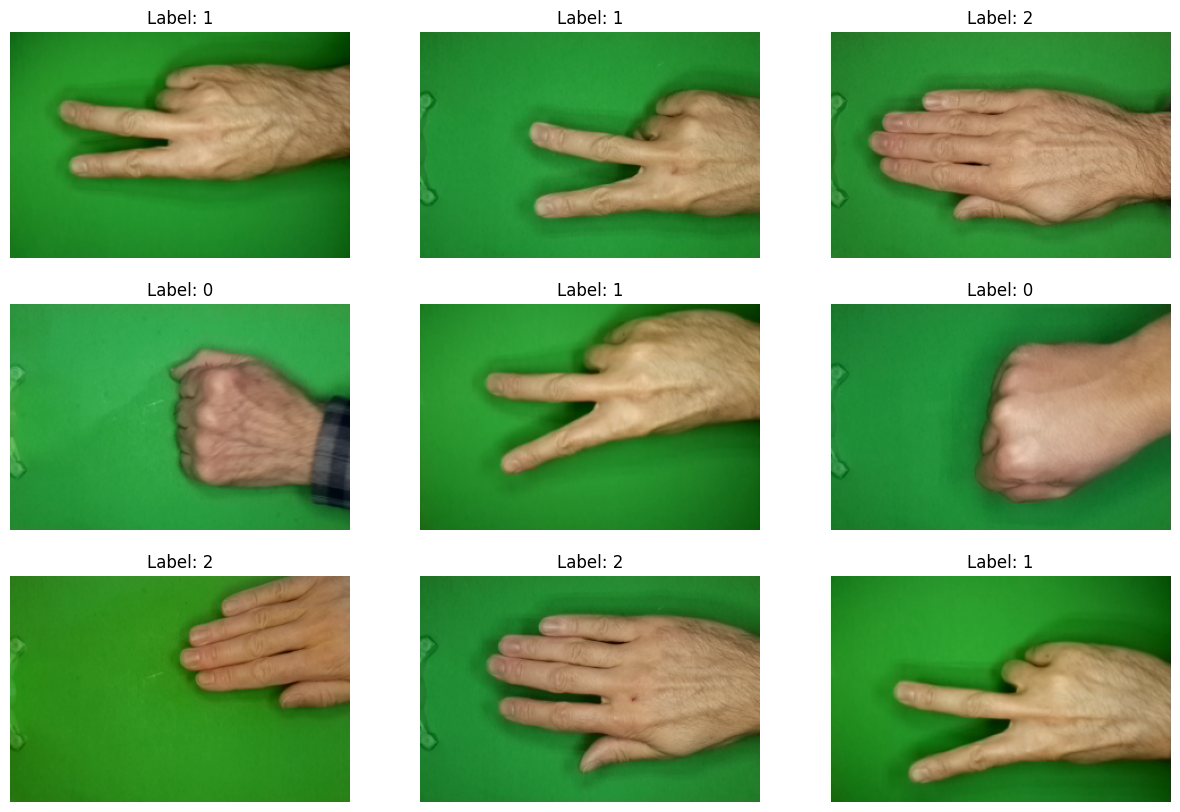

In [ ]:
# Plot the images in a 3x3 grid
plt.figure(figsize=(15, 10))
for i, sample in enumerate(sample_imgs):
    plt.subplot(3, 3, i + 1)
    img = randAgent.train_data["images"][sample]/255.
    plt.imshow(img)
    plt.axis('off')
    label = randAgent.train_data["labels"][sample]
    plt.title(f"Label: {label}")
plt.show()

## Visualise Vertical Flip

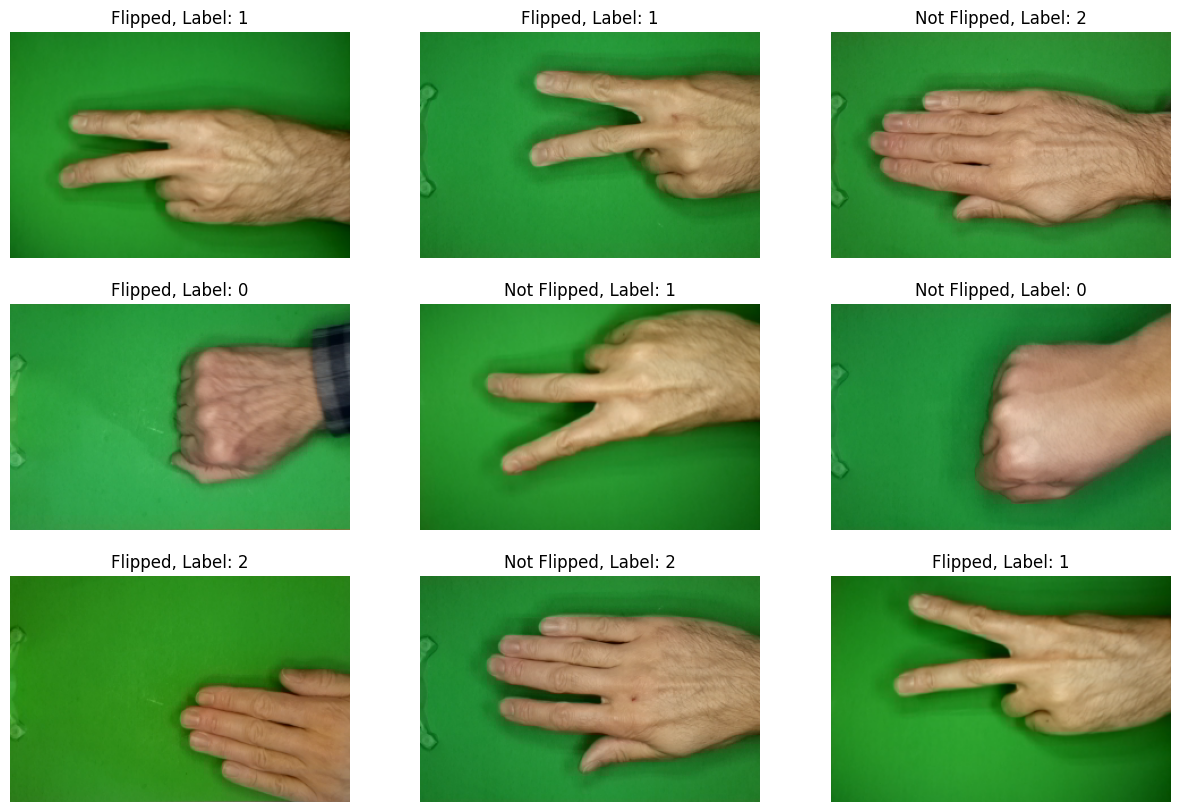

In [ ]:
# Plot the images in a 3x3 grid
plt.figure(figsize=(15, 10))
for i, sample in enumerate(sample_imgs):
    plt.subplot(3, 3, i + 1)
    img = randAgent.train_data["images"][sample]/255.
    [flipped_image, flipped] = randAgent.random_flip(img, axis='vertical')
    plt.imshow(flipped_image)
    title = "Flipped" if flipped else "Not Flipped"
    label = randAgent.train_data["labels"][sample]
    plt.title(title + f", Label: {label}")
    plt.axis('off')
plt.show()

## Visualise Horizontal Flip

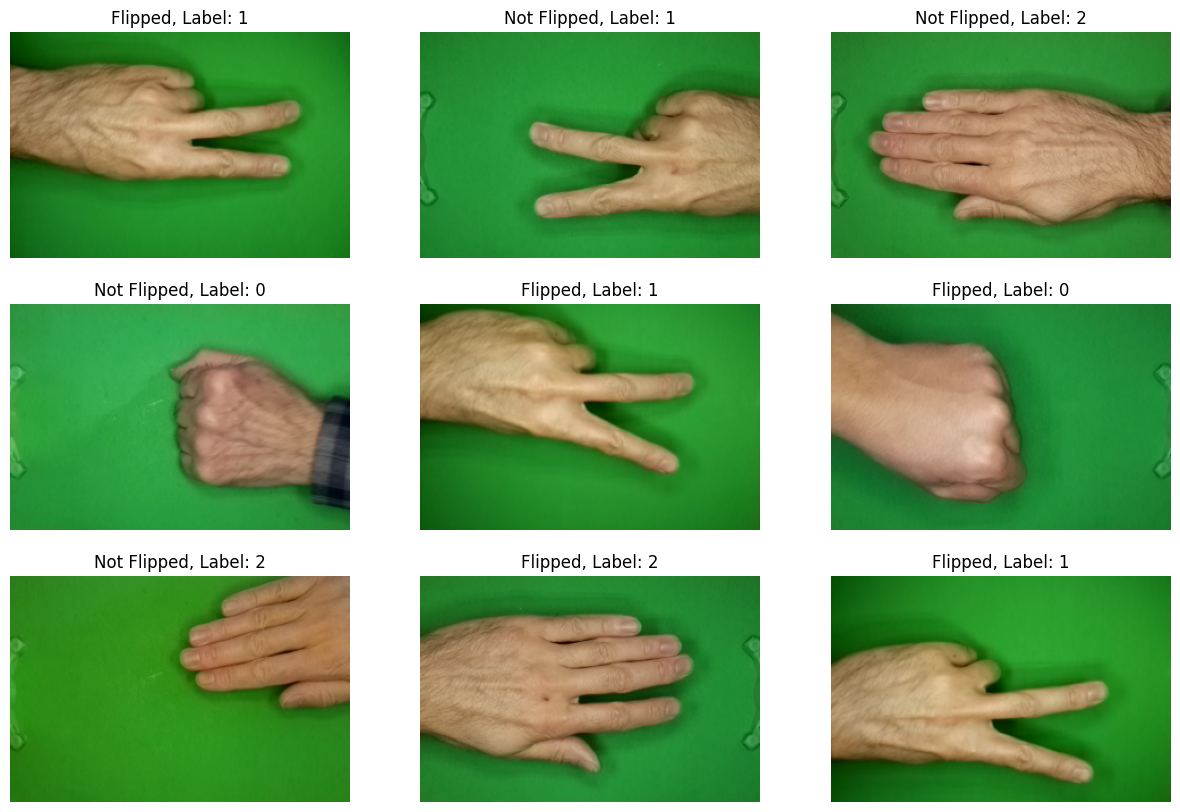

In [ ]:
# Plot the images in a 3x3 grid
plt.figure(figsize=(15, 10))
for i, sample in enumerate(sample_imgs):
    plt.subplot(3, 3, i + 1)
    img = randAgent.train_data["images"][sample]/255.
    [flipped_image, flipped] = randAgent.random_flip(img, axis='horizontal')
    plt.imshow(flipped_image)
    title = "Flipped" if flipped else "Not Flipped"
    label = randAgent.train_data["labels"][sample]
    plt.title(title + f", Label: {label}")
    plt.axis('off')
plt.show()

## Visualize White Noise

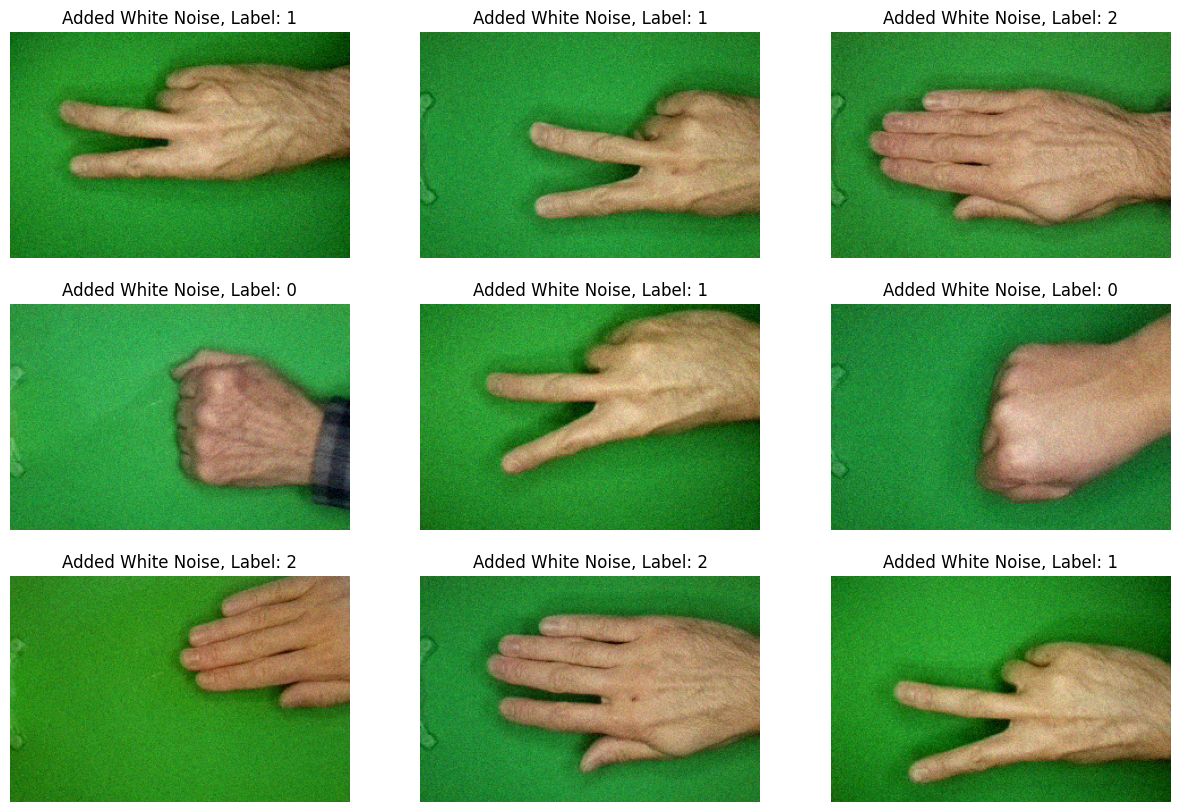

In [ ]:
# Plot the images in a 3x3 grid
plt.figure(figsize=(15, 10))
for i, sample in enumerate(sample_imgs):
    plt.subplot(3, 3, i + 1)
    img = randAgent.train_data["images"][sample]/255.
    noisy_image = randAgent.add_white_noise(img)
    label = randAgent.train_data["labels"][sample]
    title = "Added White Noise"
    plt.title(title + f", Label: {label}")
    plt.imshow(noisy_image)
    plt.axis('off')
plt.show()

# Define the Ensemble Agent

At first we will try to train various ensemble models and compare their performance in a later stage with Deep Learning models which can handle more efficiently images and transformations in them, such as CNNs.  

At first, we will get the `grayscale version` of the images to reduce the channels to 1 and resize images to (50,75) from (200,300) in order to maintain the original images' aspect ratio. Afterwards we will use `dimensionality reduction` techniques to reduce the features in each sample (200x300 = 60.000 features per grayscale sample). Finally, we will use `ensemble models` like Random Forests and Gradient Boosting as the classifier of our Agent.

## Collect Grayscale Images & Resize-Scale Data

In [ ]:
randAgentGray = RandomAgent("/content/drive/MyDrive/datasets/final")
randAgentGray.load_dataset(grayscale=True)
randAgentGray.resize_images(50, 75)

x_train, y_train = np.array(randAgentGray.train_data["images"]), np.array(randAgentGray.train_data["labels"])
x_test, y_test = np.array(randAgentGray.test_data["images"]), np.array(randAgentGray.test_data["labels"])
print(f"Shape of x_train: {x_train.shape} and y_train: {y_train.shape}")
print(f"Shape of x_test: {x_test.shape} and y_test: {y_test.shape}")
# Scale images to [0, 1]
x_train = x_train / 255.
x_test = x_test / 255.

Number of images for rock category: 726
Number of images for scissors category: 750
Number of images for paper category: 712
Images in train set: 1749 with number of labels: 1749
Images in test set: 439 with number of labels: 439
Shape of x_train: (1749, 50, 75, 1) and y_train: (1749,)
Shape of x_test: (439, 50, 75, 1) and y_test: (439,)


In [ ]:
# reshape dataset to be sklearn compatible
x_train = x_train.reshape(1749, -1)
x_test = x_test.reshape(439, -1)
print(f"Shape of x_train: {x_train.shape} and y_train: {y_train.shape}")
print(f"Shape of x_test: {x_test.shape} and y_test: {y_test.shape}")

Shape of x_train: (1749, 3750) and y_train: (1749,)
Shape of x_test: (439, 3750) and y_test: (439,)


## Preprocess Dataset (Dimensionality Reduction) & Train Ensemble Classifier

As mentioned earlier, each grayscale image consists of 60000 features. Due to the curse of dimensionality, our ML models might fail to achieve an acceptable performance particularly when our training dataset consists of only 1749 samples.  
Thus, we will try to reduce the number of features per sample, using dimensionality reduction techniques. In more detail, we will use the `kernel PCA plus LDA` algorithm. This tool is one of the best candidates because contrary to PCA it takes into consideration the label of each sample (PCA is an unsupervised learning technique, so it does not utilize the labels of samples). The main objective of this algorithm is to perform kernel PCA to make a first reduction in the unnecessary features (in Hilbert space in order to track non-linearities) and afterwards to reduce the inner class width and increase the between classes width from LDA so this can help later our classifiers to create the necessary decision boundaries more easily.

In [ ]:
# Create a pipeline with KPCA, LDA, and a classifier
pipeline = Pipeline([
    ('kpca', KernelPCA()),
    ('lda', LinearDiscriminantAnalysis()),
    ('classifier', RandomForestClassifier())  # Replace with GradientBoostingClassifier if needed
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'kpca__kernel': ['linear', 'rbf'],
    'kpca__n_components': [100, 500],
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 5, 10],
}

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(x_train, y_train)

# Print the best parameters and their corresponding accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Parameters: {'classifier__max_depth': 5, 'classifier__n_estimators': 100, 'kpca__kernel': 'rbf', 'kpca__n_components': 500}
Best Accuracy: 0.8456307818256242


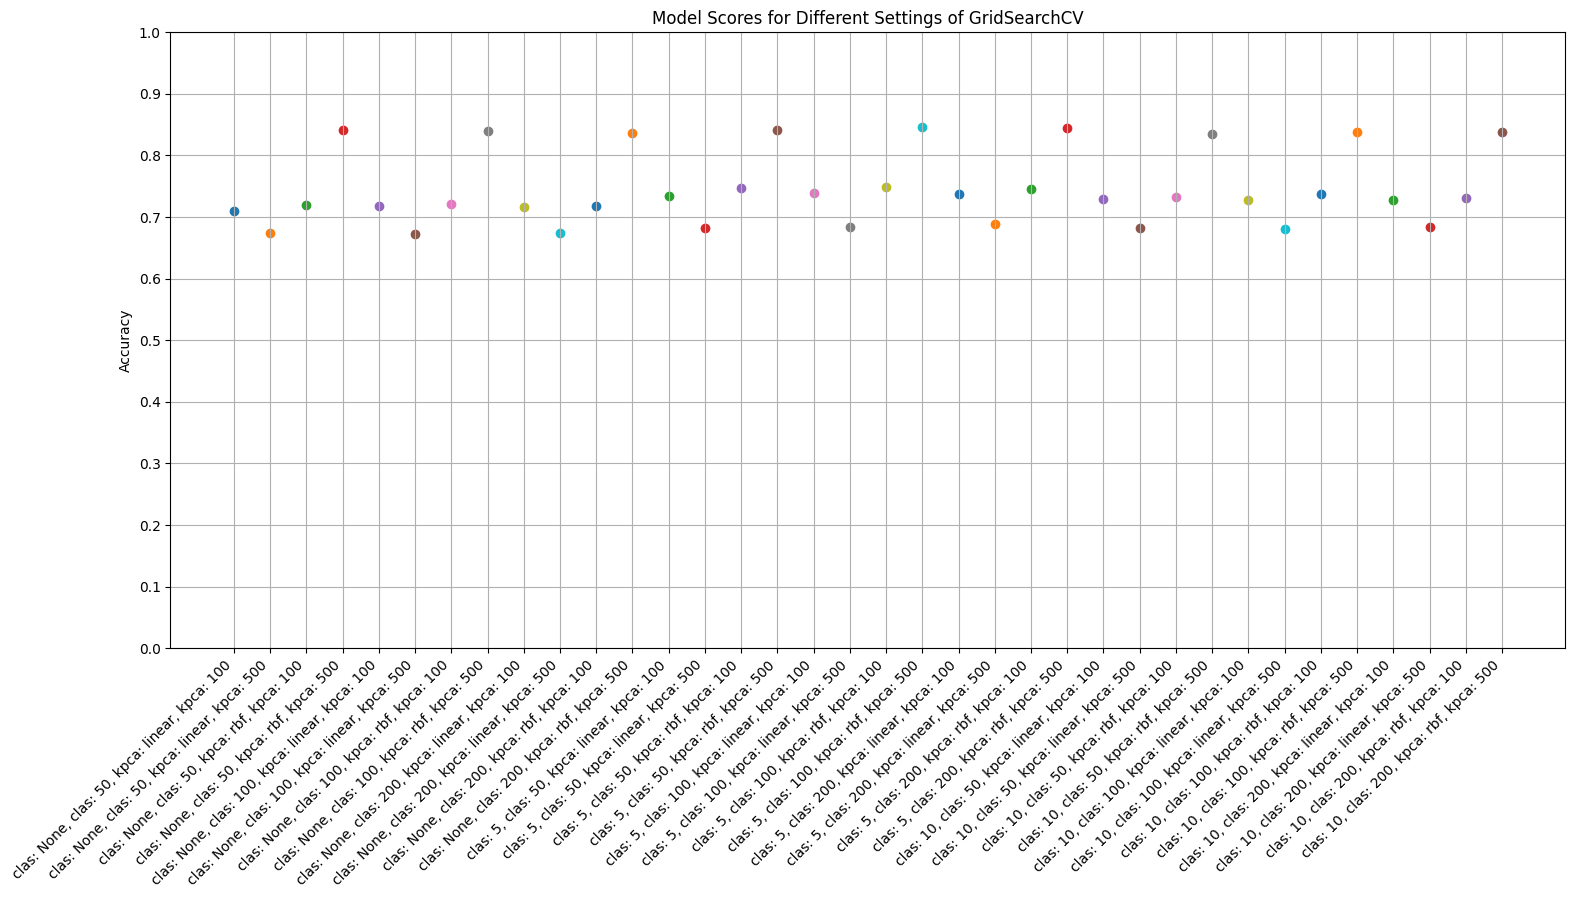

In [ ]:
# Extract the results
results = grid_search.cv_results_
param_keys = list(param_grid.keys())
param_values = [param_grid[key] for key in param_keys]
plt.figure(figsize=(18,8))
# Plot the scores with labels
for setting, score in zip(results['params'], results['mean_test_score']):
    label = ', '.join(f"{key[:4]}: {value}" for key, value in setting.items())
    plt.scatter(label, score)

# Customize the plot

plt.xticks(rotation=45, ha='right')
plt.yticks([i/10. for i in range(0,11)])
plt.ylabel('Accuracy')
plt.title('Model Scores for Different Settings of GridSearchCV')
plt.grid()
plt.show()

# Create Deep Learning Agents

As a next step, we will create AI Agents using Deep Learning techniques particularly using Convolutional Neural Networks.  
CNNs have proven to be one of the most efficient ways to classify images. They have a very strong advantage compared to other ML techniques, especially from standard NNs. They use convolutional filters which reduce massively the number of weights in the network, especially if we wanted to handle the images of the same resolution with a Fully Connected Network. Also, they can track topological information and neighboring regions much more efficiently, which makes them much more robust in transformations such as crop.
Finally, they can use data augmentation techniques which help them generalize better in the given dataset and be extremely robust in transformations introduced from the Random Agent.

## Preprocess Dataset


In [8]:
x_train, y_train = np.array(randAgent.train_data["images"]), np.array(randAgent.train_data["labels"])
x_test, y_test = np.array(randAgent.test_data["images"]), np.array(randAgent.test_data["labels"])
print(f"Shape of x_train: {x_train.shape} and y_train: {y_train.shape}")
print(f"Shape of x_test: {x_test.shape} and y_test: {y_test.shape}")

Shape of x_train: (1749, 200, 300, 3) and y_train: (1749,)
Shape of x_test: (439, 200, 300, 3) and y_test: (439,)


In [9]:
# Scale images to [0, 1]
x_train = x_train / 255.
x_test = x_test / 255.

So in this step we splitted the dataset in train and test set, so that `we will never inject information of test set in the models trained` and we will introduce it only during the final evaluation of the model with the highest performance. We will use validation set for evaluating the trained models during the training process.  
Also, it is `very important to scale our dataset` and in images particularly the most usual scaling method is to divide by 255. so each pixel will have value in range [0, 1].

## Define the CNN Agent (alpha version)

As a first experiment with CNN models, we will create a vanilla version of a CNN classifier.  
It consists of 3 Convolution layers, with Max Pooling between them and 2 fully connected layers. The activation function will be ReLU and only in the last FC layer softmax for the classification of our three labels.

In [4]:
def cnn_model():
  # Define the input layer
  input_layer = layers.Input(shape=(200, 300, 3))

In [5]:
class CNNAgentAlpha:
    def __init__(self):
      # Define the input layer
      input = layers.Input(shape=(200, 300, 3))
      # Convolutional layers
      conv1 = layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu")(input)
      maxPool1 = layers.MaxPool2D(pool_size=(2,2))(conv1)
      conv2 = layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu")(maxPool1)
      maxPool2 = layers.MaxPool2D(pool_size=(2,2))(conv2)
      conv3 = layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu")(maxPool2)
      # Fully Connected Layer
      flatten = layers.Flatten()(conv3)
      dense = layers.Dense(units=128, activation="relu")(flatten)
      output = layers.Dense(units=3, activation="softmax")(dense)
      # create model
      self.model = models.Model(inputs=input, outputs=output)
      # compile model
      self.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

    def train_model(self, x_train, y_train, epochs=10, val_split=0.2, batch_size=64):
        # Train the model
        history = self.model.fit(x_train, y_train, epochs=epochs,
                       validation_split=val_split, batch_size=batch_size)
        return history

    def evaluate_model(self, x_test, y_test):
        # Evaluate the model
        test_loss, test_acc = self.model.evaluate(x_test, y_test)
        print(f'Test Accuracy: {test_acc}')

    def predict(self, img):
        return self.model.predict(img)

In [6]:
cnnAgentA = CNNAgentAlpha()
cnnAgentA.model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 300, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 198, 298, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 99, 149, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 147, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 73, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 71, 64)        36928 

In [10]:
historyA = cnnAgentA.train_model(x_train, y_train, epochs=30)

Epoch 1/30
22/22 [==============================] - 15s 337ms/step - loss: 1.9325 - accuracy: 0.4825 - val_loss: 1.2880 - val_accuracy: 0.1514
Epoch 2/30
22/22 [==============================] - 3s 129ms/step - loss: 0.5498 - accuracy: 0.8127 - val_loss: 1.2089 - val_accuracy: 0.5771
Epoch 3/30
22/22 [==============================] - 3s 115ms/step - loss: 0.2822 - accuracy: 0.9078 - val_loss: 0.6224 - val_accuracy: 0.7600
Epoch 4/30
22/22 [==============================] - 3s 116ms/step - loss: 0.1680 - accuracy: 0.9421 - val_loss: 0.3024 - val_accuracy: 0.9029
Epoch 5/30
22/22 [==============================] - 2s 112ms/step - loss: 0.1000 - accuracy: 0.9678 - val_loss: 0.3310 - val_accuracy: 0.9057
Epoch 6/30
22/22 [==============================] - 3s 116ms/step - loss: 0.0411 - accuracy: 0.9886 - val_loss: 1.0999 - val_accuracy: 0.7171
Epoch 7/30
22/22 [==============================] - 3s 127ms/step - loss: 0.0261 - accuracy: 0.9907 - val_loss: 0.4829 - val_accuracy: 0.8629
Epoch

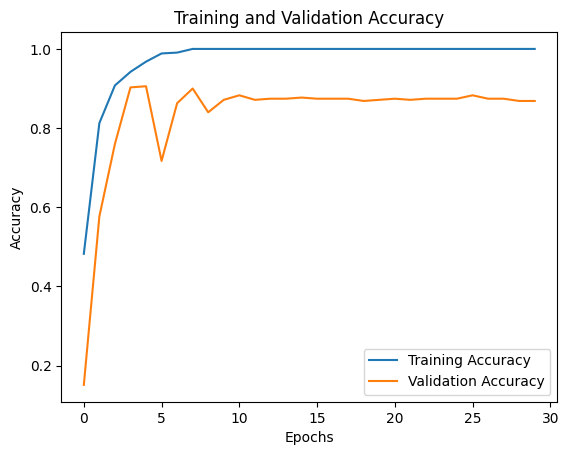

In [11]:
train_acc = historyA.history['accuracy']
val_acc = historyA.history['val_accuracy']
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Model Assessment

It is clear that the model `suffers from overfitting (high variance)` because there is a significant gap between the train and validation accuracy, with approximately `87% accuracy in validation set`. One of the most powerful solutions to this problem is `regularization`. We can achieve this by enhancing the previous Agent with `L2 regularization (Weight Decay)`.

## Define the CNN Agent V2 (Regularization)

In [ ]:
class CNNAgentBeta:
    def __init__(self):
      # Define the input layer
      input = layers.Input(shape=(200, 300, 3))
      # Convolutional layers
      conv1 = layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", kernel_regularizer=regularizers.l2(1e-3))(input)
      maxPool1 = layers.MaxPool2D(pool_size=(2,2))(conv1)
      conv2 = layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu", kernel_regularizer=regularizers.l2(1e-3))(maxPool1)
      maxPool2 = layers.MaxPool2D(pool_size=(2,2))(conv2)
      conv3 = layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu", kernel_regularizer=regularizers.l2(1e-3))(maxPool2)
      # Fully Connected Layer
      flatten = layers.Flatten()(conv3)
      dense = layers.Dense(units=128, activation="relu", kernel_regularizer=regularizers.l2(1e-3))(flatten)
      output = layers.Dense(units=3, activation="softmax")(dense)
      # create model
      self.model = models.Model(inputs=input, outputs=output)
      # compile model
      self.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

    def train_model(self, x_train, y_train, epochs=10, val_split=0.2, batch_size=64):
        # Train the model
        history = self.model.fit(x_train, y_train, epochs=epochs,
                       validation_split=val_split, batch_size=batch_size)
        return history

    def evaluate_model(self, x_test, y_test):
        # Evaluate the model
        test_loss, test_acc = self.model.evaluate(x_test, y_test)
        print(f'Test Accuracy: {test_acc}')

    def predict(self, img):
        return self.model.predict(img)

In [ ]:
cnnAgentB = CNNAgentBeta()
cnnAgentB.model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 200, 300, 3)]     0         
                                                                 
 conv2d_15 (Conv2D)          (None, 198, 298, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 99, 149, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 97, 147, 64)       18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 48, 73, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 46, 71, 64)        3692

In [ ]:
historyB = cnnAgentB.train_model(x_train, y_train, epochs=30)

Epoch 1/30
22/22 [==============================] - 6s 165ms/step - loss: 2.6768 - accuracy: 0.4789 - val_loss: 1.7328 - val_accuracy: 0.0000e+00
Epoch 2/30
22/22 [==============================] - 3s 122ms/step - loss: 0.9842 - accuracy: 0.7498 - val_loss: 0.9116 - val_accuracy: 0.7829
Epoch 3/30
22/22 [==============================] - 3s 118ms/step - loss: 0.7116 - accuracy: 0.8520 - val_loss: 0.8196 - val_accuracy: 0.7857
Epoch 4/30
22/22 [==============================] - 3s 117ms/step - loss: 0.5472 - accuracy: 0.8964 - val_loss: 0.9908 - val_accuracy: 0.7514
Epoch 5/30
22/22 [==============================] - 3s 142ms/step - loss: 0.4326 - accuracy: 0.9299 - val_loss: 0.7227 - val_accuracy: 0.8286
Epoch 6/30
22/22 [==============================] - 3s 146ms/step - loss: 0.3248 - accuracy: 0.9507 - val_loss: 0.7579 - val_accuracy: 0.8200
Epoch 7/30
22/22 [==============================] - 3s 134ms/step - loss: 0.2497 - accuracy: 0.9778 - val_loss: 0.5572 - val_accuracy: 0.8686
Ep

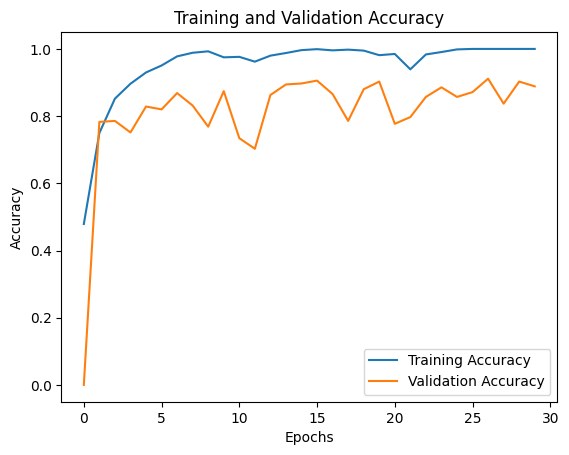

In [ ]:
train_acc = historyB.history['accuracy']
val_acc = historyB.history['val_accuracy']
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Model Assessment

From the upper results, we can conclude that the regularization had an impact on the training process, as the training accuracy needed more epochs to reach 100%. However still the validation accuracy has a significant gap in the upper plot, `reaching 88% accuracy in the validation set`, so we have to explore further techniques. One other solution that can help us achieve greater accuracy in the validation set is `Data Augmentation`. This can also help the Agent be more robust in the image alternations from the Random Agent so it's the best possible modification that we can explore.

## Define CNN Agent V3 (Data Augmentation)

In [ ]:
class CNNAgentAugmented:
    def __init__(self):
      # Define the input layer
      input = layers.Input(shape=(200, 300, 3))
      # Data Augmentation
      rotated_input = layers.RandomRotation(factor=(-0.2, 0.3))(input)
      flipped_input = layers.RandomFlip()(rotated_input)
      cropped_input = layers.RandomCrop(200, 300)(flipped_input)
      augmented_input = layers.RandomContrast(0.2)(cropped_input)

      # Convolutional layers
      conv1 = layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", kernel_regularizer=regularizers.l2(1e-3))(augmented_input)
      maxPool1 = layers.MaxPool2D(pool_size=(2,2))(conv1)
      conv2 = layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu", kernel_regularizer=regularizers.l2(1e-3))(maxPool1)
      maxPool2 = layers.MaxPool2D(pool_size=(2,2))(conv2)
      conv3 = layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu", kernel_regularizer=regularizers.l2(1e-3))(maxPool2)
      # Fully Connected Layer
      flatten = layers.Flatten()(conv3)
      dense = layers.Dense(units=128, activation="relu", kernel_regularizer=regularizers.l2(1e-3))(flatten)
      output = layers.Dense(units=3, activation="softmax")(dense)
      # create model
      self.model = models.Model(inputs=input, outputs=output)
      # compile model
      self.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

    def train_model(self, x_train, y_train, epochs=10, val_split=0.2, batch_size=64):
        # Train the model
        history = self.model.fit(x_train, y_train, epochs=epochs,
                       validation_split=val_split, batch_size=batch_size)
        return history

    def evaluate_model(self, x_test, y_test):
        # Evaluate the model
        test_loss, test_acc = self.model.evaluate(x_test, y_test)
        print(f'Test Accuracy: {test_acc}')

    def predict(self, img):
        return self.model.predict(img)

In [ ]:
cnnAgentAugm = CNNAgentAugmented()
cnnAgentAugm.model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 300, 3)]     0         
                                                                 
 random_rotation (RandomRot  (None, 200, 300, 3)       0         
 ation)                                                          
                                                                 
 random_flip (RandomFlip)    (None, 200, 300, 3)       0         
                                                                 
 random_crop (RandomCrop)    (None, 200, 300, 3)       0         
                                                                 
 random_contrast (RandomCon  (None, 200, 300, 3)       0         
 trast)                                                          
                                                                 
 conv2d (Conv2D)             (None, 198, 298, 32)      896   

In [ ]:
historyC = cnnAgentAugm.train_model(x_train, y_train, epochs=60)

Epoch 1/60
22/22 [==============================] - 22s 365ms/step - loss: 2.6640 - accuracy: 0.4089 - val_loss: 1.5284 - val_accuracy: 0.4486
Epoch 2/60
22/22 [==============================] - 3s 126ms/step - loss: 1.2364 - accuracy: 0.5218 - val_loss: 1.2093 - val_accuracy: 0.7229
Epoch 3/60
22/22 [==============================] - 3s 127ms/step - loss: 1.1264 - accuracy: 0.5940 - val_loss: 1.5236 - val_accuracy: 0.3914
Epoch 4/60
22/22 [==============================] - 3s 126ms/step - loss: 0.9078 - accuracy: 0.7291 - val_loss: 1.4983 - val_accuracy: 0.5429
Epoch 5/60
22/22 [==============================] - 3s 146ms/step - loss: 0.8444 - accuracy: 0.7434 - val_loss: 1.2040 - val_accuracy: 0.5514
Epoch 6/60
22/22 [==============================] - 3s 159ms/step - loss: 0.7086 - accuracy: 0.8263 - val_loss: 1.7375 - val_accuracy: 0.4800
Epoch 7/60
22/22 [==============================] - 3s 125ms/step - loss: 0.6282 - accuracy: 0.8456 - val_loss: 1.9388 - val_accuracy: 0.2314
Epoch

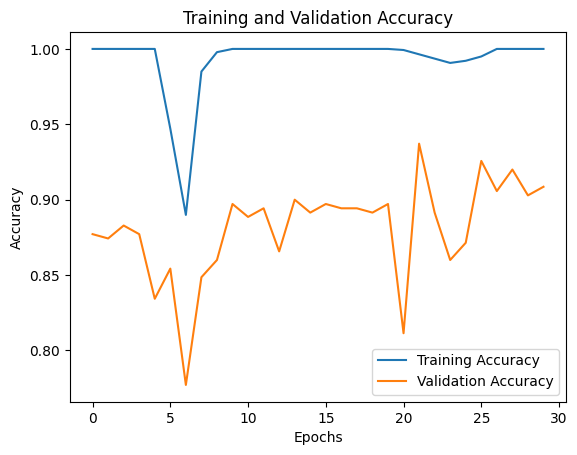

In [ ]:
train_acc = historyC.history['accuracy']
val_acc = historyC.history['val_accuracy']
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Model Assessment

So, using the data augmentation technique we managed to increase even further the performance of the model with approximately `89% accuracy in the validation set`. This Agent variant is also expected to be `far more robust in the transformations of the Random Agent` than the previous variants. However, there is still a technique worth trying to create a model with even higher performance. This technique is called `Transfer Learning` and the basic idea behind it is to use a pretrained model and retrain only a small portion of it on our dataset. That way a powerful model that has already been trained to recognize useful patterns in images can feed its encoded info into some newly added Fully Connected layers which will be trained from scratch for our specific application. Afterwards, we will use the technique called `Finetuning` to retrain the whole model with a very small learning rate, in order to readjust even the weights of the base model in our specific applications and get even better results.

## Define CNN Agent V4 (Transfer Learning)

In [ ]:
class CNNAgentTransferLearning:
    def __init__(self):
      self.base_model = applications.Xception(
        weights='imagenet',  # Load weights pre-trained on ImageNet.
        input_shape=(200, 300, 3),
        include_top=False)  # Do not include the ImageNet classifier at the top.
      self.base_model.trainable = False
      # Define the input layer
      input = layers.Input(shape=(200, 300, 3))
      # Data Augmentation
      rotated_input = layers.RandomRotation(factor=(-0.2, 0.3))(input)
      flipped_input = layers.RandomFlip()(rotated_input)
      cropped_input = layers.RandomCrop(200, 300)(flipped_input)
      augmented_input = layers.RandomContrast(0.2)(cropped_input)

      imagenet_output = self.base_model(augmented_input, training=False)
      flatten = layers.Flatten()(imagenet_output)
      dense1 = layers.Dense(units=128, activation="relu", kernel_regularizer=regularizers.l2(1e-3))(flatten)
      dense2 = layers.Dense(units=64, activation="relu", kernel_regularizer=regularizers.l2(1e-3))(dense1)
      output = layers.Dense(units=3, activation="softmax")(dense2)
      # create model
      self.model = models.Model(inputs=input, outputs=output)
      # compile model
      self.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

    def train_model(self, x_train, y_train, epochs=10, val_split=0.2, batch_size=256):
        # Train the model
        history = self.model.fit(x_train, y_train, epochs=epochs,
                       validation_split=val_split, batch_size=batch_size)
        return history

    def evaluate_model(self, x_test, y_test):
        # Evaluate the model
        test_loss, test_acc = self.model.evaluate(x_test, y_test)
        print(f'Test Accuracy: {test_acc}')

    def predict(self, img):
        return self.model.predict(img)

In [ ]:
cnnAgentTransf = CNNAgentTransferLearning()
cnnAgentTransf.model.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 300, 3)]     0         
                                                                 
 random_rotation (RandomRot  (None, 200, 300, 3)       0         
 ation)                                                          
                                                                 
 random_flip (RandomFlip)    (None, 200, 300, 3)       0         
                                                                 
 random_crop (RandomCrop)    (None, 200, 300, 3)       0         
                                                                 
 random_contrast (RandomCon  (None, 200, 300, 3)       0         
 trast)                                                          
                                                              

In [ ]:
historyD = cnnAgentTransf.train_model(x_train, y_train, epochs=40)

Epoch 1/40
6/6 [==============================] - 48s 8s/step - loss: 4.2163 - accuracy: 0.6290 - val_loss: 5.5162 - val_accuracy: 0.4000
Epoch 2/40
6/6 [==============================] - 10s 2s/step - loss: 1.2972 - accuracy: 0.8742 - val_loss: 0.8326 - val_accuracy: 0.9371
Epoch 3/40
6/6 [==============================] - 11s 2s/step - loss: 0.8021 - accuracy: 0.9543 - val_loss: 1.2867 - val_accuracy: 0.8943
Epoch 4/40
6/6 [==============================] - 11s 2s/step - loss: 0.7206 - accuracy: 0.9693 - val_loss: 0.7714 - val_accuracy: 0.9600
Epoch 5/40
6/6 [==============================] - 11s 2s/step - loss: 0.7071 - accuracy: 0.9757 - val_loss: 1.0111 - val_accuracy: 0.8543
Epoch 6/40
6/6 [==============================] - 11s 2s/step - loss: 0.6582 - accuracy: 0.9807 - val_loss: 0.7004 - val_accuracy: 0.9686
Epoch 7/40
6/6 [==============================] - 11s 2s/step - loss: 0.5882 - accuracy: 0.9843 - val_loss: 1.2033 - val_accuracy: 0.9029
Epoch 8/40
6/6 [==================

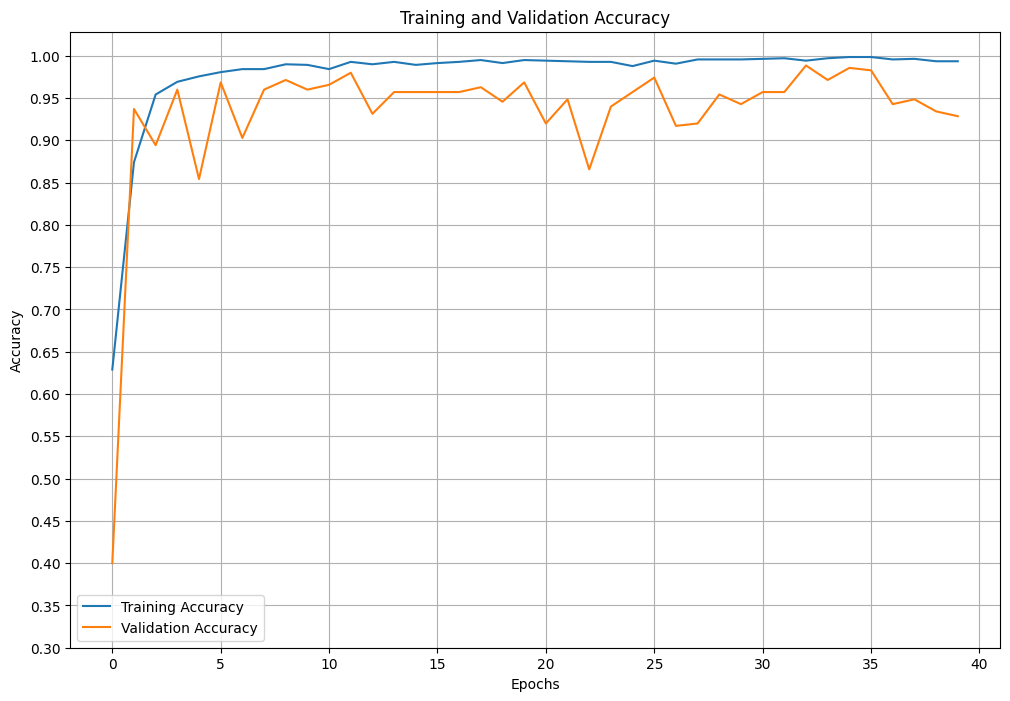

In [ ]:
plt.figure(figsize=(12,8))
train_acc = historyD.history['accuracy']
val_acc = historyD.history['val_accuracy']
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.yticks([i/20. for i in range(6,21)])
plt.grid()
plt.legend()
plt.show()

### Finetuning the model

In [ ]:
# Unfreeze the base model
cnnAgentTransf.base_model.trainable = True

# finetune the whole with very low learning rate
cnnAgentTransf.model.compile(optimizer=optimizers.Adam(1e-5), loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

# Train end-to-end. Be careful to stop before you overfit!
historyE = cnnAgentTransf.model.fit(x_train, y_train, epochs=10, validation_split=0.2, batch_size=64)

Epoch 1/10
22/22 [==============================] - 99s 3s/step - loss: 0.1394 - accuracy: 0.9964 - val_loss: 0.1903 - val_accuracy: 0.9886
Epoch 2/10
22/22 [==============================] - 28s 1s/step - loss: 0.1358 - accuracy: 0.9964 - val_loss: 0.3461 - val_accuracy: 0.9514
Epoch 3/10
22/22 [==============================] - 29s 1s/step - loss: 0.1385 - accuracy: 0.9964 - val_loss: 0.4909 - val_accuracy: 0.9486
Epoch 4/10
22/22 [==============================] - 28s 1s/step - loss: 0.1238 - accuracy: 0.9971 - val_loss: 0.1235 - val_accuracy: 1.0000
Epoch 5/10
22/22 [==============================] - 28s 1s/step - loss: 0.1212 - accuracy: 0.9986 - val_loss: 0.2322 - val_accuracy: 0.9743
Epoch 6/10
22/22 [==============================] - 28s 1s/step - loss: 0.1158 - accuracy: 0.9993 - val_loss: 0.1266 - val_accuracy: 0.9943
Epoch 7/10
22/22 [==============================] - 29s 1s/step - loss: 0.1114 - accuracy: 1.0000 - val_loss: 0.1360 - val_accuracy: 0.9914
Epoch 8/10
22/22 [==

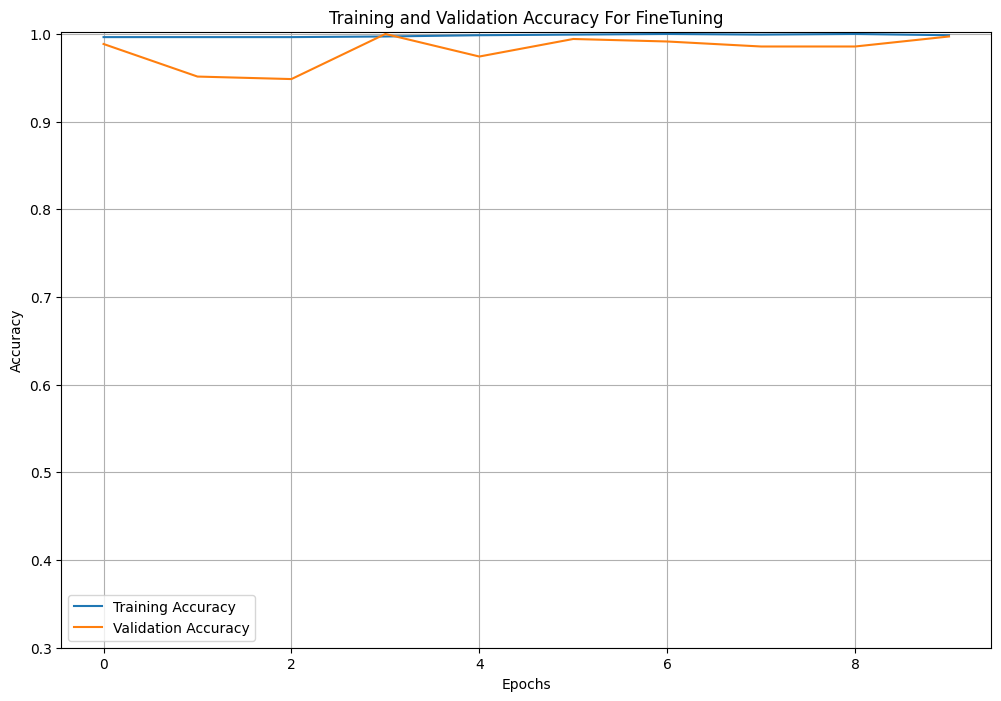

In [ ]:
plt.figure(figsize=(12,8))
train_acc = historyE.history['accuracy']
val_acc = historyE.history['val_accuracy']
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy For FineTuning')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.yticks([i/10. for i in range(3,11)])
plt.grid()
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12,8))
train_acc = historyD.history['accuracy'] + historyE.history['accuracy']
val_acc = historyD.history['val_accuracy'] + historyE.history['val_accuracy']
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy For Total Training Process')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.yticks([i/20. for i in range(6,21)])
plt.grid()
plt.legend()
plt.show()

### Save/Load the model

In [ ]:
from keras.models import load_model
# cnnAgentTransf.model.save("/content/drive/MyDrive/datasets/final/my_cnn_TL_model.keras")

cnnAgentTransf.model = load_model("/content/drive/MyDrive/datasets/final/my_cnn_TL_model.keras")

The training process of our top performance model was very time and resources consuming, so it was very important to take advantage of the save and load utilities offered by keras. By saving the model we actually stored all the necessary information of the model's architecture and the values of the weights occured after the training process so that the model could be used for inference (predictions) only by loading the trained model.

### Final Evaluation of the Model

In [ ]:
test_loss, test_acc = cnnAgentTransf.model.evaluate(x_test, y_test)
print(f"Accuracy achieved in test set: {test_acc*100.:.3f}%")

14/14 [==============================] - 2s 149ms/step - loss: 0.1313 - accuracy: 0.9886
Accuracy achieved in test set: 98.861%


### Model Assessment

So the final model created by utilizing the `transfer learning technique in ImageNet` pre-trained model achieved almost `99% accuracy in the test set`!  
This significant boost in performance was achieved because we used transfer learning with a pretrained variant of ImageNet as a based model and a custom Fully Connected classifier in the last layers.   
In the first step, we froze the base model and trained only the dense layers we added on top. The pretrained weights of the highly efficient Imagenet architecture could help also derive some useful information for our specific task of recognizing hand signs of rock-paper-scissors. After this step, the model achieved approximately 97% of accuracy in the validation set.  
We moved one step further by unfreezing the layers of the base model and training the whole model this time with a relatively low learning rate, a procedure known as finetuning. After that process, the model achieved `accuracy close to 100% in the validation set` which is far higher than the previous attempts.

# RSP Game Environment

In [ ]:
class RSPEnvironment:
  def __init__(self, n, randomAgent, myAgent) -> None:
    self.score = []
    self.numRounds = n
    self.randomAgent = randomAgent
    self.myAgent = myAgent
    self.wrongClfImgs = []

  def run(self, is_keras=True):
    for i in range(self.numRounds):
      move_id = self.randomAgent.get_random_img(dataset="test")
      # print(move_id)
      opponents_move = np.array(self.randomAgent.test_data["images"][move_id])
      # perform the same scaling
      opponents_move = opponents_move / 255.
      # randomAgent's image transformations
      [opponents_move, _] = randAgent.random_flip(opponents_move, axis='vertical')
      [opponents_move, _] = randAgent.random_flip(opponents_move, axis='horizontal')
      opponents_move = randAgent.add_white_noise(opponents_move)
      if is_keras:
        opponents_move = opponents_move.reshape(1,200,300,3)
      else:
        opponents_move = opponents_move.reshape(1, -1)
      # print(opponents_move.shape)
      # gather agents' moves
      opponents_move_type = self.randomAgent.test_data["labels"][move_id]
      # print(opponents_move_type)
      randomAgents_move = self.randomAgent.get_random_prediction()
      # print(randomAgents_move)
      if is_keras:
        myAgents_move = np.argmax(self.myAgent.model.predict([opponents_move], verbose=0))
      else:
        myAgents_move = self.myAgent.predict(opponents_move)
      # print(myAgents_move)
      if myAgents_move == opponents_move_type == randomAgents_move:
        # print("Both agents win")
        self.score.append(1)
      elif myAgents_move == opponents_move_type and randomAgents_move != opponents_move_type:
        self.score.append(2)
        # print("Only my Agent wins")
      elif myAgents_move != opponents_move_type and randomAgents_move == opponents_move_type:
        self.score.append(-1)
        self.wrongClfImgs.append(opponents_move)
        print(f"Only random Agent wins in round {i}")
      else:
        self.score.append(0)
        self.wrongClfImgs.append(opponents_move)
        print(f"No Agent wins in round {i}")

## Initialize and Run with Ensemble Agent in RSP Environment

In [ ]:
env = RSPEnvironment(1000, randAgentGray, grid_search.best_estimator_)
env.run(is_keras=False)

No Agent wins in round 2
Only random Agent wins in round 4
Only random Agent wins in round 5
No Agent wins in round 9
No Agent wins in round 10
No Agent wins in round 11
No Agent wins in round 15
No Agent wins in round 21
Only random Agent wins in round 23
No Agent wins in round 27
No Agent wins in round 31
No Agent wins in round 35
No Agent wins in round 37
No Agent wins in round 39
No Agent wins in round 45
Only random Agent wins in round 47
Only random Agent wins in round 49
No Agent wins in round 57
No Agent wins in round 58
Only random Agent wins in round 59
Only random Agent wins in round 60
Only random Agent wins in round 67
No Agent wins in round 69
No Agent wins in round 70
No Agent wins in round 73
No Agent wins in round 77
No Agent wins in round 83
No Agent wins in round 84
No Agent wins in round 85
No Agent wins in round 89
No Agent wins in round 90
No Agent wins in round 91
No Agent wins in round 93
No Agent wins in round 94
No Agent wins in round 97
No Agent wins in round

### Evaluate Agents in RSP Environment

In [ ]:
print(f"Number of missclassified images from Ensemble Agent: {len(env.wrongClfImgs)}")
print(f"Number of missclassified images from both Agents: {env.score.count(0)}")
print(f"Number of missclassified images only from Ensemble Agents: {env.score.count(-1)}")
print(f"Accuracy of Ensemble Agent: {(len(env.score)-len(env.wrongClfImgs))*100/len(env.score):.3}%")
print(f"Accuracy of Random Agent: {(env.score.count(1)+env.score.count(-1))*100/len(env.score):.3}%")

Number of missclassified images from Ensemble Agent: 392
Number of missclassified images from both Agents: 278
Number of missclassified images only from Ensemble Agents: 114
Accuracy of Ensemble Agent: 60.8%
Accuracy of Random Agent: 32.2%


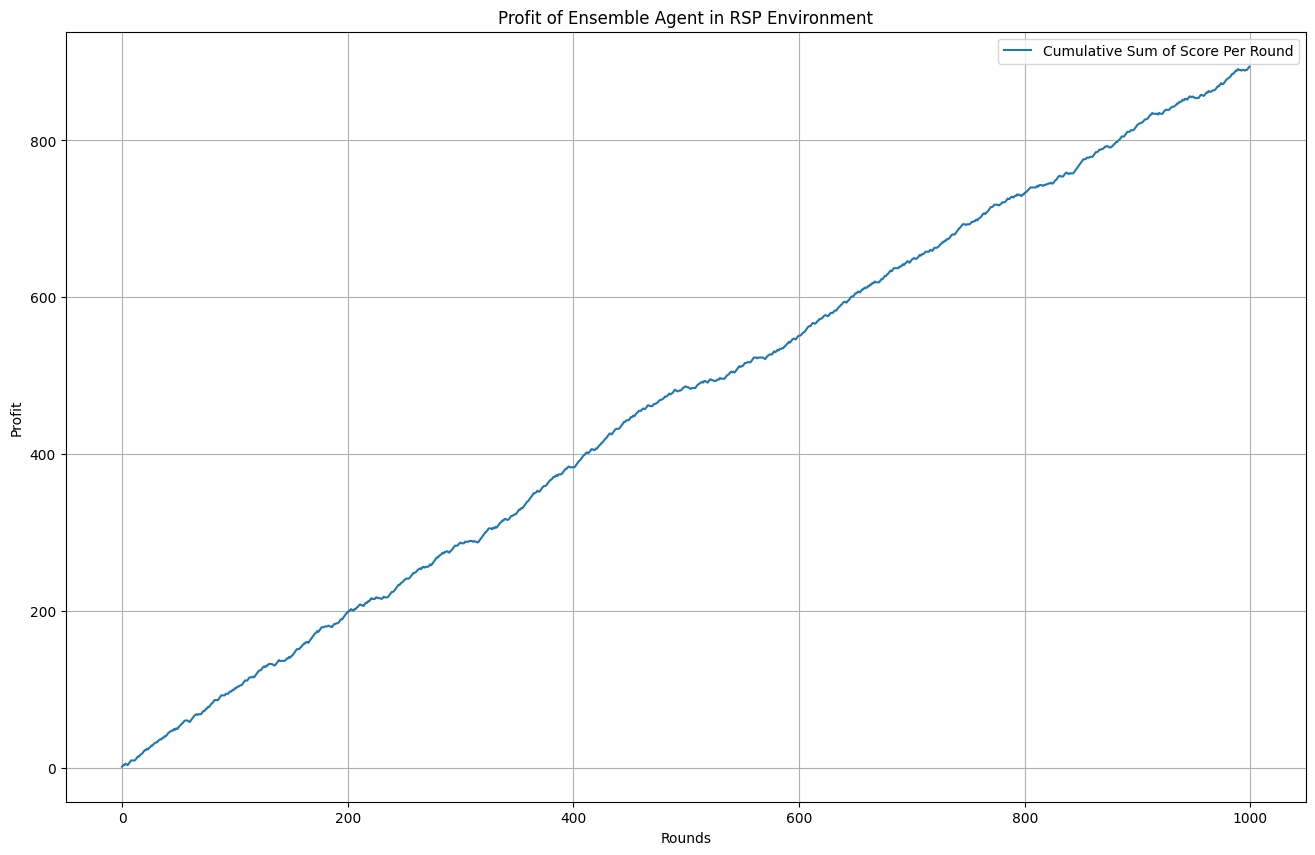

In [ ]:
plt.figure(figsize=(16,10))
plt.plot([i for i in range(len(env.score))], np.cumsum(env.score), label="Cumulative Sum of Score Per Round")
plt.title('Profit of Ensemble Agent in RSP Environment')
plt.xlabel('Rounds')
plt.ylabel('Profit')
plt.legend()
plt.grid()
plt.show()

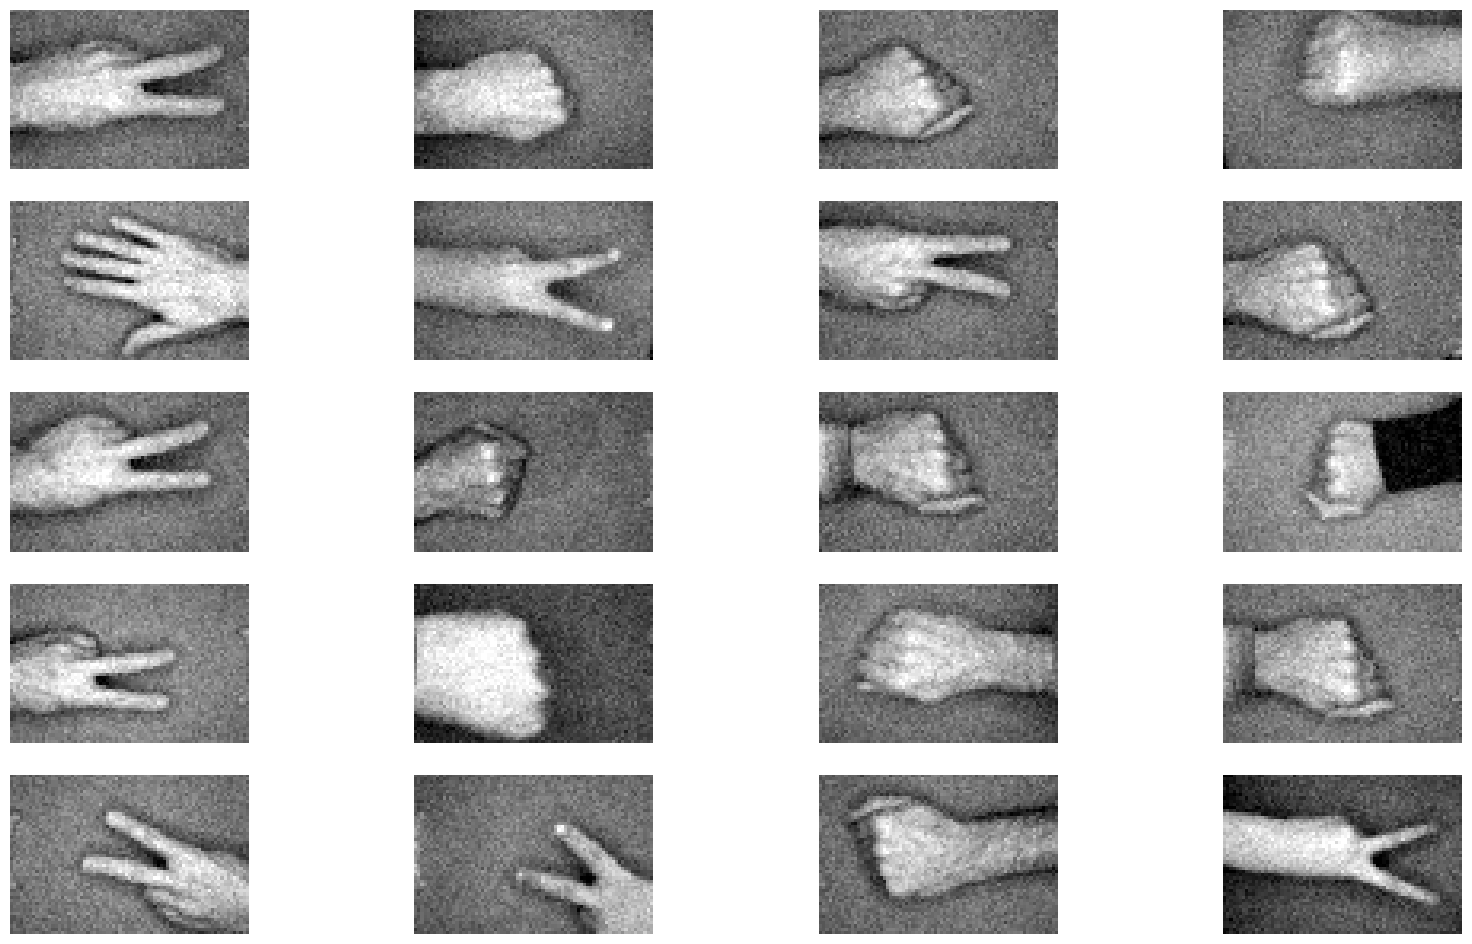

In [ ]:
# Plot the images in a 3x3 grid
plt.figure(figsize=(20, 12))
sample_imgs = env.wrongClfImgs[:20]
for i, sample in enumerate(sample_imgs):
    plt.subplot(5, 4, i + 1)
    plt.imshow(sample.reshape(50,75), cmap='gray')
    plt.axis('off')
    # label = randAgent.train_data["labels"][sample]
    # plt.title(f"Label: {label}")
plt.show()

From the upper results, we can conclude that the ensemble classifier had an acceptable performance and `managed to collect a profit` even after the transformations occurred from the Random Agent. However the `final accuracy of 60% in the test set` from the Ensemble Agent is not the best result we can achieve and `we expect the CNN Agent V4 to outperform the Ensemble Agent` because it should be more robust in the transformations of the Random Agent and can handle far better the information of images thanks to the convolutional filters instead of just reshaping each image to a vector of values and `destroying every topological information contained in them`.  
Finally, it is clear that the Ensemble Agent `failed to classify correctly mostly images with added noise` from the Random Agent, a behavior that we expected and tried to resolve through the data augmentation technique in the heavily more robust `CNN Agent V4` which will be evaluated next.

## Initialize and Run with CNN Agent V4 in RSP Environment

In [ ]:
env = RSPEnvironment(1000, randAgent, cnnAgentTransf)
env.run()

No Agent wins in round 18
Only random Agent wins in round 78
No Agent wins in round 83
No Agent wins in round 103
No Agent wins in round 170
No Agent wins in round 190
Only random Agent wins in round 243
Only random Agent wins in round 244
Only random Agent wins in round 309
No Agent wins in round 321
No Agent wins in round 326
Only random Agent wins in round 336
Only random Agent wins in round 356
No Agent wins in round 373
Only random Agent wins in round 467
No Agent wins in round 483
No Agent wins in round 499
No Agent wins in round 523
Only random Agent wins in round 532
Only random Agent wins in round 559
No Agent wins in round 579
Only random Agent wins in round 605
No Agent wins in round 607
No Agent wins in round 617
Only random Agent wins in round 624
Only random Agent wins in round 670
Only random Agent wins in round 719
No Agent wins in round 741
No Agent wins in round 763
No Agent wins in round 838
Only random Agent wins in round 856
Only random Agent wins in round 913
No A

### Evaluate Agents in RSP Environment

In [ ]:
print(f"Number of missclassified images from CNN Agent: {len(env.wrongClfImgs)}")
print(f"Number of missclassified images from both Agents: {env.score.count(0)}")
print(f"Number of missclassified images only from CNN Agents: {env.score.count(-1)}")
print(f"Accuracy of CNN Agent: {(len(env.score)-len(env.wrongClfImgs))*100/len(env.score):.3}%")
print(f"Accuracy of Random Agent: {(env.score.count(1)+env.score.count(-1))*100/len(env.score):.3}%")


Number of missclassified images from CNN Agent: 36
Number of missclassified images from both Agents: 20
Number of missclassified images only from CNN Agents: 16
Accuracy of CNN Agent: 96.4%
Accuracy of Random Agent: 34.0%


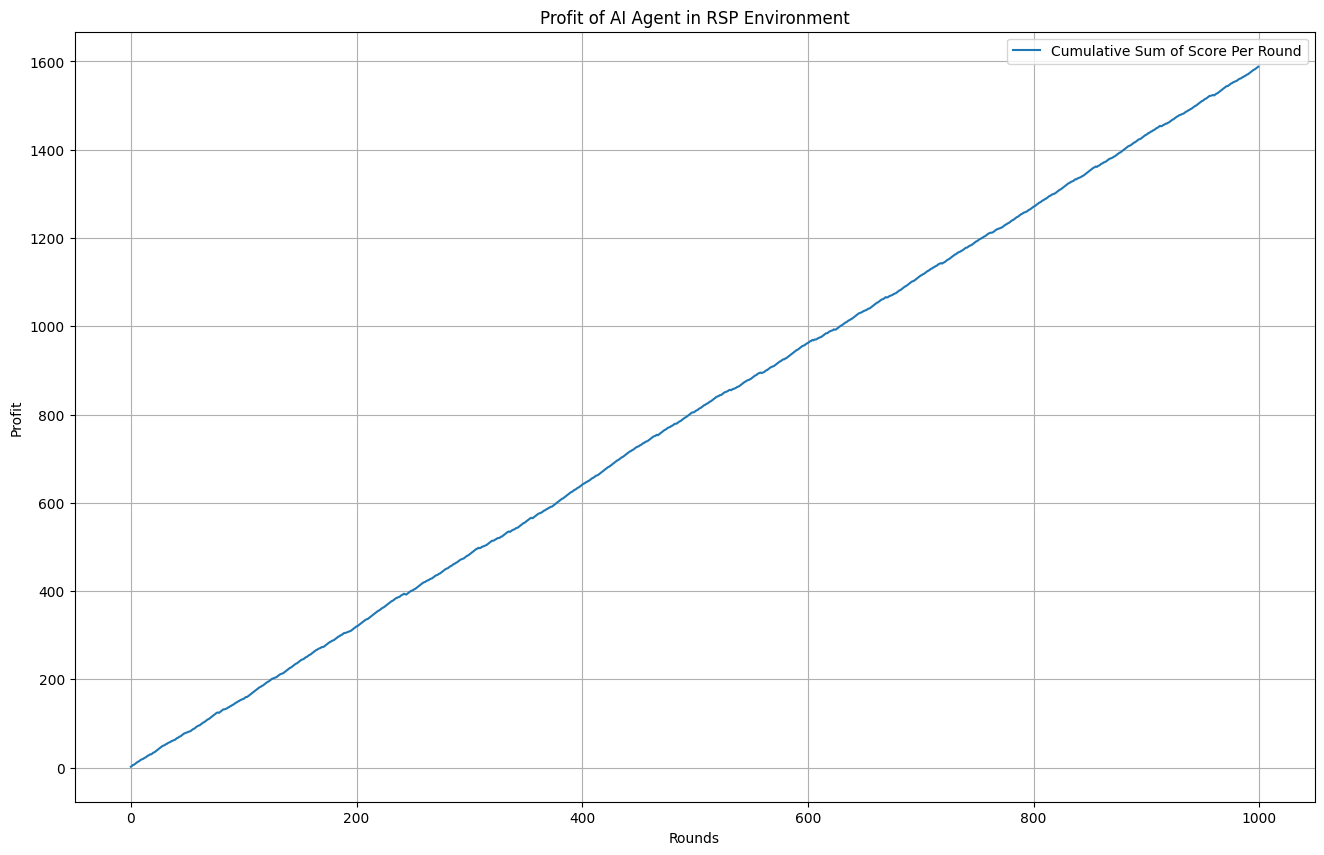

In [ ]:
plt.figure(figsize=(16,10))
plt.plot([i for i in range(len(env.score))], np.cumsum(env.score), label="Cumulative Sum of Score Per Round")
plt.title('Profit of AI Agent in RSP Environment')
plt.xlabel('Rounds')
plt.ylabel('Profit')
plt.legend()
plt.grid()
plt.show()

### Plot Missclassified Samples from our CNN Agent V4

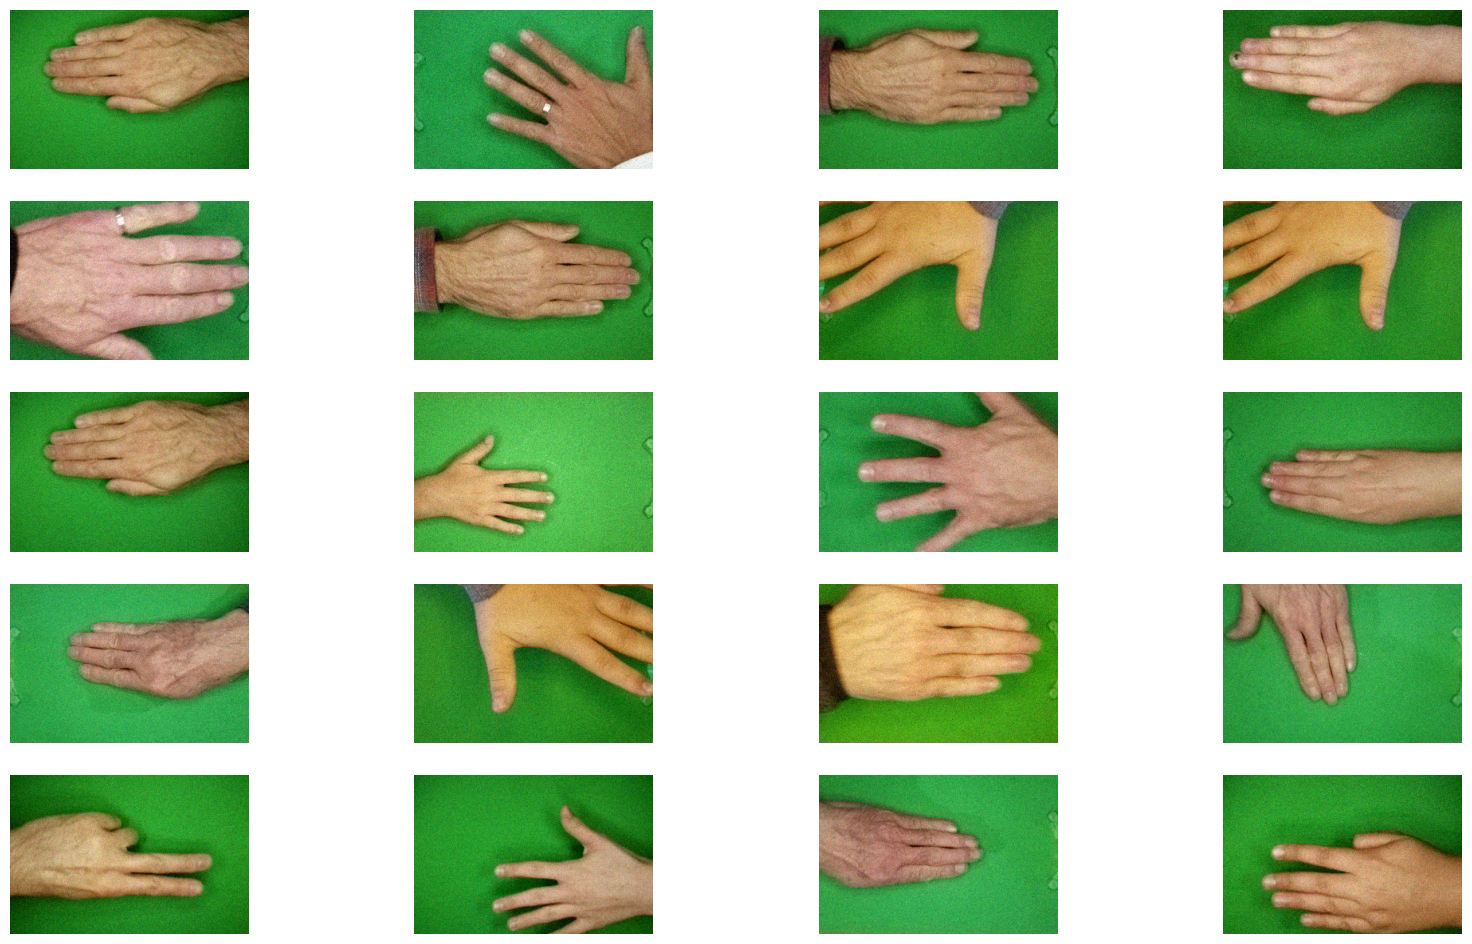

In [ ]:
# Plot the images in a 3x3 grid
plt.figure(figsize=(20, 12))
sample_imgs = env.wrongClfImgs[:20]
for i, sample in enumerate(sample_imgs):
    plt.subplot(5, 4, i + 1)
    plt.imshow(sample.reshape(200,300,3))
    plt.axis('off')
    # label = randAgent.train_data["labels"][sample]
    # plt.title(f"Label: {label}")
plt.show()

So, in the RSP environment, the CNN Agent V4 as we expected outperformed the Ensemble Agent and of course the Random Agent even after the transformations occurred in the test images. We got a tremendous performance in `the test set of 96.4% accuracy after 1000 rounds` of the Rock-Scissor-Paper game!
So with the CNN Agent V4, the added noise seems to not have as much impact on the performance as in the Ensemble Agent. Most of the misclassified images are open fingers (Paper) which might confuse the Agent to classify them as Scissors and `even a human annotator in many of these cases`.

# Custom Dataset Evaluation with CNN Agent V4

In [ ]:
f_path = "/content/drive/MyDrive/datasets/final/mySet"
files = os.listdir(f_path)
images = []
for f_i, f_name in enumerate(files):
    img_path = os.path.join(f_path, f_name)
    images.append(img_to_array(load_img(img_path)))
images = np.array(images)
print(f"Shape of custom images dataset: {images.shape}")
# perform the same scaling
images = images / 255.

Shape of custom images dataset: (3, 200, 300, 3)


In [ ]:

pred = np.argmax(cnnAgentTransf.model.predict(images, verbose=0), axis=0)
print(f"Predictions for custom set: {pred}")

Predictions for custom set: [1 0 2]


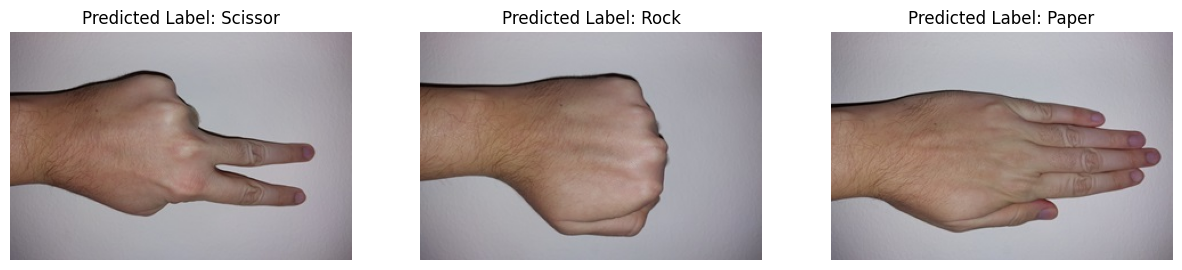

In [ ]:
label_dict = {0:"Rock", 1:"Scissor", 2:"Paper"}
# Plot the images in a 3x3 grid
plt.figure(figsize=(15, 10))
sample_imgs = images
for i, sample in enumerate(sample_imgs):
    plt.subplot(1, 3, i + 1)
    plt.imshow(sample.reshape(200,300,3))
    plt.axis('off')
    # label = randAgent.train_data["labels"][sample]
    plt.title(f"Predicted Label: {label_dict[pred[i]]}")
plt.show()

In [ ]:
# map the predicted moves to their winning moves
move_map = {0: "Paper", 1:"Rock", 2:"Scissor"}
for i, val in enumerate(pred):
  print(f"Proposed move from our CNN Agent V4 for image {i}: {move_map[val]}")

Proposed move from our CNN Agent V4 for image 0: Rock
Proposed move from our CNN Agent V4 for image 1: Paper
Proposed move from our CNN Agent V4 for image 2: Scissor


As we see from the upper results the CNN Agent `successfully predicted and proposed the winning move for all the custom images taken from us`. This means that the model created generalized well thanks to the `data augmentation` techniques, the `regularization` and of course the `transfer learning and finetuning` in the `Inception pre-trained model`.

# Conclusion

To sum up the findings of the upper workflow, `the AI Agent V4 had an exceptional performance in the Rock-Scissor-Paper game resembled in RSP Environment with 96.4% accuracy achieved in the test set even after the transformation occurred from the Random Agent`. The key ideas that helped the Random Agent V4 to outperform all the other agents were the Transfer Learning and Finetuning with the Inception model and of course, the Data Augmentation technique applied during training.  
However, for training such models the need for computational power was increased so it was important to train the CNN models in GPU, something that was not necessary for training the ML ensemble models.  
Regarding the ML models, their performance was limited compared to the DL models, something that we expected, due to the efficiency of CNN models to handle images as their input.  
Also, for the ML models, it was very important to work with images in Grayscale format and resize them to get a final vector of shape (3750,). The reshaping of the images to 1-dimensional vectors as explained earlier destroyed a significant part of the topological information of neighboring regions contained in the raw form of images and can be used from models like CNNs. With the CNN models, there was no need for such operations so all pixels were used, and all 3 channels of the RGB format. Dimensionality reduction algorithms were also used for the ensemble models to reduce even further the features of each sample. After all these techniques the ensemble models achieved a score of 88% in the validation set and approximately 60% in the RSP environment, a score far lower than from the CNN Agent.